# PFDA project

***

Weather data from [MET Eireann Historical Data](https://www.met.ie/climate/available-data/historical-data).

In [1]:
# import plotting library
import matplotlib.pyplot as plt

# import data analysis library
import pandas as pd

# import statistical library
import seaborn as sns

# import predictive data analysis library
import sklearn

import numpy as np

In [2]:
# data sources
carlow_data_url = "https://cli.fusio.net/cli/climate_data/webdata/mly375.csv"
donegal_data_url = "https://cli.fusio.net/cli/climate_data/webdata/mly1575.csv"

In [3]:
# load the data from the urls into DataFrames
carlow_df = pd.read_csv(carlow_data_url, skiprows=18, low_memory=False)
donegal_df = pd.read_csv(donegal_data_url, skiprows=18, low_memory=False)

In [4]:
# extract windspeed and year columns
carlow_selected = carlow_df[['year', 'wdsp']].copy()
# rename wdsp in new column called 'wdsp_carlow'
carlow_selected.rename(columns={'wdsp': 'wdsp_carlow'}, inplace=True)

donegal_selected = donegal_df[['year', 'wdsp']].copy()
donegal_selected.rename(columns={'wdsp': 'wdsp_donegal'}, inplace=True)

Merging dataframes:

- https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#merge

In [5]:
# merge the datasets on year column
combined_df = pd.merge(carlow_selected, donegal_selected, on='year')

In [6]:
df=combined_df
# print truncated version of dataframe
combined_df

,year,wdsp_carlow,wdsp_donegal
0,2004,8.4,17.2
1,2004,8.4,17.0
2,2004,8.4,16.8
3,2004,8.4,15.3
4,2004,8.4,10.8
...,...,...,...
2927,2024,7.1,14.4
2928,2024,7.1,11.5
2929,2024,7.1,15.9
2930,2024,7.1,13.6


Clean data a bit

In [7]:
# replace empty strings with NaN
df = df.replace(["", " ", "NA", "null"], np.nan)

In [8]:
# check how many missing entries in each column
df.isna().sum()


year             0
wdsp_carlow     24
wdsp_donegal    12
dtype: int64

In [9]:
# view the first row in the dataframe
df.iloc[0]

year            2004
wdsp_carlow      8.4
wdsp_donegal    17.2
Name: 0, dtype: object

In [10]:
# view datatypes
df.dtypes

year             int64
wdsp_carlow     object
wdsp_donegal    object
dtype: object

Windseed isnt numeric. Convert entire df to numeric first.

In [11]:
# convert to all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [12]:
# check df again
df.dtypes

year              int64
wdsp_carlow     float64
wdsp_donegal    float64
dtype: object

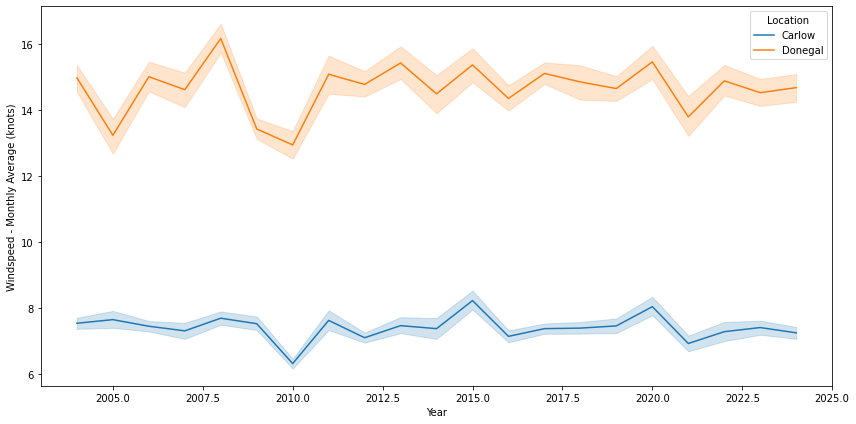

In [13]:
# plot line using seaborn
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=df, x='year', y='wdsp_carlow', label='Carlow')
sns.lineplot(data=df, x='year', y='wdsp_donegal', label='Donegal')

# decorate the plot
plt.xlabel("Year")
plt.ylabel("Windspeed - Monthly Average (knots)")
#plt.title(f"wi")
plt.legend(title='Location')

plt.tight_layout()

***

### END